In [1]:
import numpy as np
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

sess = tf.Session()

%matplotlib inline

In [2]:
a = 2.6
b = 5.0

factorial = lambda n: tf.exp(tf.lgamma(n + 1))

def func(x, a=a, b=b):
    def beta(a,b):
        return tf.exp(tf.math.lgamma(a))*tf.exp(tf.math.lgamma(b)) / tf.exp(tf.math.lgamma(a+b))
    Z = 1.5
    return (1/Z)*(x**(a-1) * (1-x)**(b-1)) / beta(a,b)

def log_func(x, a=a, b=b):
    return tf.log(func(x, a=a, b=b))

def mode(a=a, b=b):
    return tf.constant((a-1) / (a + b - 2), dtype=tf.float32)

def taylor_series(function, x, point, truncate):
    eval_taylor = function(point)
    grad = function(point)
    for i in range(1, truncate+1):
        i = float(i)
        grad = tf.gradients(grad, point)
        eval_taylor += (grad / factorial(i))*(x - point)**i
    return eval_taylor, grad

/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


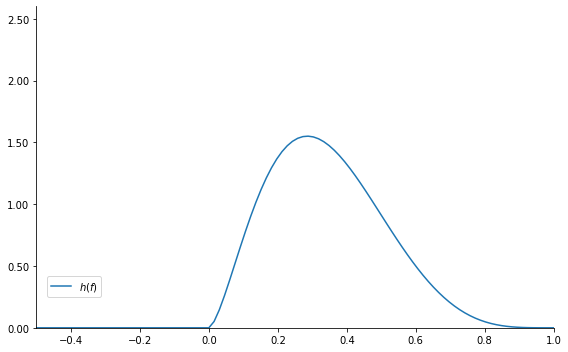

In [3]:
x = np.linspace(-0.5,1.0,100).astype(np.float64)
f = func
log_f = log_func
m = mode

fig_unnormalised_posterior, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(x, np.nan_to_num(sess.run(f(x))), color='C0', label='$h(f)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
ax.set_ylim(0.0, 2.6)
ax.set_xlim(x.min(), x.max())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig_unnormalised_posterior.tight_layout()
fig_unnormalised_posterior.savefig('taylor/hf.pdf')

/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


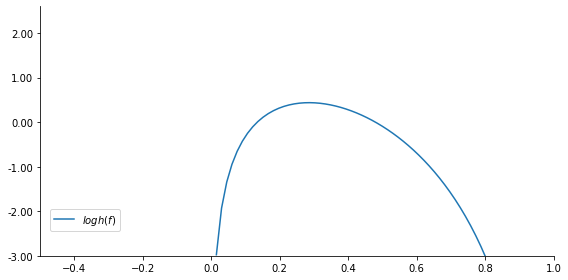

In [4]:
#x_log = np.linspace(0.0, 0.5, 100)
x_log = x

fig_log_unnormalised_posterior, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(x_log, sess.run(log_f(x_log)), 'C0', label='$log h(f)$')
#ax.axvline(sess.run(m()), color='r', linestyle='--', label='Mode $\hat{f}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
ax.set_ylim(-3.0, 2.6)
ax.set_xlim(x_log.min(), x_log.max())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig_log_unnormalised_posterior.tight_layout()
fig_log_unnormalised_posterior.savefig('taylor/log_hf.pdf')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


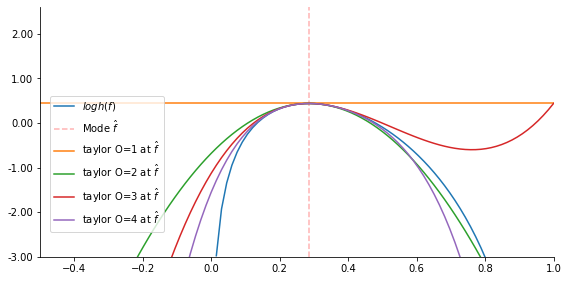

In [5]:
fig_taylor, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(x_log, sess.run(log_f(x_log)), 'C0', label='$log h(f)$')
ax.axvline(sess.run(m()), color='r', linestyle='--', label='Mode $\hat{f}$', alpha=0.3)

for n in range(1, 5):
    taylor, _ = sess.run(taylor_series(
        function=log_f,
        x=x_log, 
        point=m(),
        truncate=n))

    ax.plot(x_log, taylor, 'C{}'.format(n), label='taylor O={}'.format(n) + ' at $\hat{f}$')
    ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-3.0, 2.6)
    ax.set_xlim(x_log.min(), x_log.max())
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig_taylor.tight_layout()
    fig_taylor.savefig('taylor/log_hf_taylor_{}.pdf'.format(n))

/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


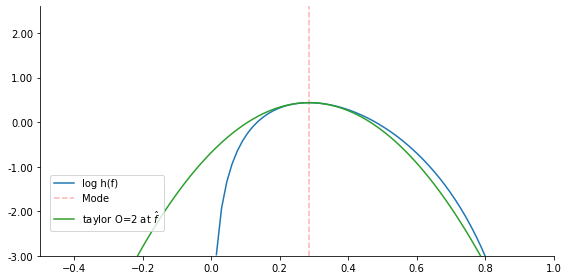

In [6]:
fig_taylor_2, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(x_log, sess.run(log_f(x_log)), 'C0', label='log h(f)')
ax.axvline(sess.run(m()), color='r', linestyle='--', label='Mode', alpha=0.3)

taylor, hessian = sess.run(taylor_series(
        function=log_f,
        x=x_log, 
        point=m(),
        truncate=2))
ax.plot(x_log, taylor, 'C{}'.format(2), label='taylor O=2 at $\hat{f}$')
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-3, 2.6)
ax.set_xlim(x_log.min(), x_log.max())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig_taylor_2.tight_layout()
fig_taylor_2.savefig('taylor/log_hf_taylor_2_only.pdf'.format(n))

Now we move back into probability space, and use a Gaussian approximation with this hessian

In [7]:
W = 1.0/(-hessian[0])

/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


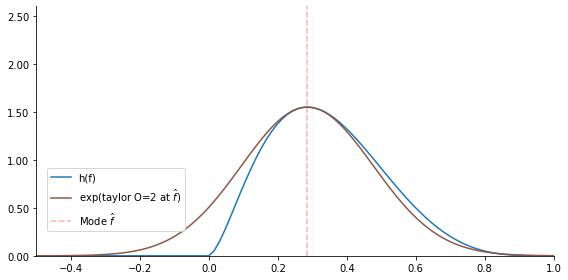

In [8]:
fig_exp_approx, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(x, np.nan_to_num(sess.run(f(x))), 'C0', label='h(f)')

taylor_exp = sess.run(tf.exp(taylor_series(
        function=log_f,
        x=x, 
        point=m(),
        truncate=2)[0]))
ax.plot(x, taylor_exp, 'C5', label='exp(taylor O=2 at $\hat{f}$)')
ax.axvline(sess.run(m()), color='r', linestyle='--', label='Mode $\hat{f}$', alpha=0.3)
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0.0, 2.6)
ax.set_xlim(x.min(), x.max())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig_exp_approx.tight_layout()
fig_exp_approx.savefig('taylor/exp_approx.pdf'.format(n))


/Users/alansaul/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


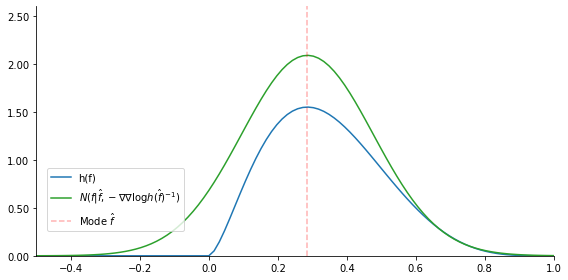

In [9]:

fig_norm_approx, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(x, np.nan_to_num(sess.run(f(x))), 'C0', label='h(f)')
ax.plot(x,
         stats.norm.pdf(x=x, 
                        loc = sess.run(m()),
                        scale = np.sqrt(W)),
         #\frac{d^{2} log h(\hat{f})}{\hat{f}^{2}}
         'C2', label='$N(f|\hat{f}, -\\nabla \\nabla \log h(\hat{f})^{-1})$'
        )

ax.axvline(sess.run(m()), color='r', linestyle='--', label='Mode $\hat{f}$', alpha=0.3)
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.08))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0.0, 2.6)
ax.set_xlim(x.min(), x.max())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig_norm_approx.tight_layout()
fig_norm_approx.savefig('taylor/norm_approx.pdf'.format(n))